In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### Read data

In [2]:
def get_data(path, batch_size, is_train, should_shuffle):
    dataset = datasets.FashionMNIST(
        path,
        train=is_train,
        download=True,
        transform=transforms.ToTensor()
    )
    return torch.utils.data.DataLoader(
        dataset=dataset, 
        batch_size=batch_size, 
        shuffle=should_shuffle
    )

In [3]:
batch_size = 16

train_loader = get_data('./data_train', batch_size, True, True)
test_loader = get_data('./data_test', batch_size, False, False)

In [4]:
# check size of images
for X_train, y_train in train_loader:
    print(f'X_train: {X_train.shape}, {X_train.type()}')
    print(f'y_train: {y_train.shape}, {y_train.type()}')
    break

X_train: torch.Size([16, 1, 28, 28]), torch.FloatTensor
y_train: torch.Size([16]), torch.LongTensor


In [5]:
img_side = 28
img_size_tuple = (img_side, img_side)
img_size = img_side * img_side

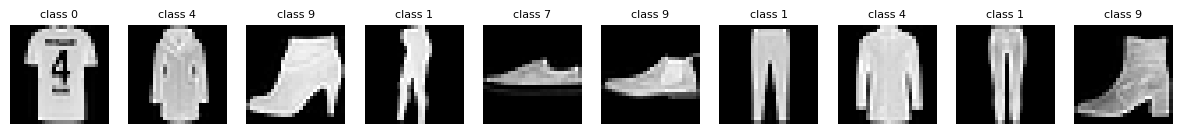

In [6]:
plt.figure(figsize=(15,15))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(img_size_tuple), cmap='gray')
    plt.title(f'class {y_train[i]}', fontsize=8)

plt.show()

### Create NN & train funs

In [7]:
class Net(nn.Module):
    
    def __init__(self, ):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(img_size, 50)
        self.fc1_drop = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = x.view(-1, img_size)
        
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        
        return F.log_softmax(self.fc3(x), dim=1)
    
##################################################
model = Net()
print(model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()
##################################################

def train(epoch, log_interval):
    # switch model into train state
    model.train()
    
    for i, (data, target) in enumerate(train_loader):
        # reset gradient from previous step
        optimizer.zero_grad()
        
        # calculate prediction
        predictions = model(data)
        # calculate loss and gradient
        loss = criterion(predictions, target)
        loss.backward()
        
        # subtract gradient
        optimizer.step()
        
        if i % log_interval == 0:
            items_processed = i * len(data)
            items_total = len(train_loader.dataset)
            percent = 100 * items_processed / items_total
            print(f'epoch {epoch: 2}, {items_processed: 6}/{items_total}/{percent:2.0f}%, loss {loss.data:.3f}')
            
def test(loss, accuracy):
    # switch model to evaluation state
    model.eval()
    
    # accumulate loss and number of correct predictions
    val_loss = 0
    correct = 0
    
    for data, target in test_loader:
        # calculate predictions
        predictions = model(data)
        # accumulate loss
        val_loss += criterion(predictions, target)
        # get class predictions from predictions
        predictions_only = predictions.data.max(1)[1]
        # accumulate correct predictions
        correct += predictions_only.eq(target.data)
    
    # len(test_loader) - returns number of batches
    # len(test_loader.dataset) - returns number of items in batch
    
    # calculate average loss. Loss was calcylated per batch => len(test_loader) => averager per batch
    val_loss /= len(test_loader)
    loss.append(val_loss)
    
    # accuracy was calculated per item => len(test_loader.dataset) => average per item
    accur = 100.0 * correct.to(torch.float32).sum() / len(test_loader.dataset)
    accuracy.append(accur)
    
    print(f'test set: avg loss={val_loss:.3f}, accuracy={accur:.3f}\n')

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


### Train

In [8]:
%%time
epochs = 5
loss = []
accuracy = []

for epoch in range(epochs):
    train(epoch, 200)
    test(loss, accuracy)

epoch  0,      0/60000/ 0%, loss 2.353
epoch  0,   3200/60000/ 5%, loss 1.943
epoch  0,   6400/60000/11%, loss 1.247
epoch  0,   9600/60000/16%, loss 1.068
epoch  0,  12800/60000/21%, loss 1.352
epoch  0,  16000/60000/27%, loss 0.947
epoch  0,  19200/60000/32%, loss 0.604
epoch  0,  22400/60000/37%, loss 0.771
epoch  0,  25600/60000/43%, loss 0.821
epoch  0,  28800/60000/48%, loss 0.800
epoch  0,  32000/60000/53%, loss 0.640
epoch  0,  35200/60000/59%, loss 0.585
epoch  0,  38400/60000/64%, loss 0.400
epoch  0,  41600/60000/69%, loss 0.671
epoch  0,  44800/60000/75%, loss 0.508
epoch  0,  48000/60000/80%, loss 0.647
epoch  0,  51200/60000/85%, loss 0.629
epoch  0,  54400/60000/91%, loss 0.621
epoch  0,  57600/60000/96%, loss 0.426
test set: avg loss=0.535, accuracy=80.960

epoch  1,      0/60000/ 0%, loss 0.420
epoch  1,   3200/60000/ 5%, loss 0.591
epoch  1,   6400/60000/11%, loss 0.595
epoch  1,   9600/60000/16%, loss 0.866
epoch  1,  12800/60000/21%, loss 0.614
epoch  1,  16000/6000